
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 統計

:label: `sec_statistics`

間違いなく、トップの深層学習実践者になるには、最先端の高精度モデルをトレーニングする能力が重要です。ただし、改善がいつ顕著になるか、またはトレーニング プロセスのランダムな変動の結果に過ぎないのかが不明瞭なことがよくあります。推定値の不確実性について議論できるようにするには、いくつかの統計を学ぶ必要があります。

*統計*に関する最も古い言及は、$9^{\mathrm{th}}$ 世紀のアラブ学者アル キンディに遡ります。彼は、暗号化されたメッセージを解読するために統計と周波数分析を使用する方法について詳細に説明しました。 800 年後、1700 年代にドイツで現代の統計が誕生しました。当時、研究者たちは人口統計と経済のデータ収集と分析に焦点を当てていました。今日、統計はデータの収集、処理、分析、解釈、視覚化に関係する科学の主題です。さらに、統計の中核理論は、学界、産業界、政府内の研究で広く使用されています。

より具体的には、統計は*記述統計*と*統計的推論*に分けることができます。前者は、*サンプル*と呼ばれる観察データのコレクションの特徴を要約して示すことに重点を置いています。サンプルは*母集団*から抽出され、実験の対象となる類似の個人、アイテム、またはイベントの合計セットを指します。記述統計とは対照的に、*統計的推論は*、標本*分布*が母集団分布をある程度再現できるという仮定に基づいて、特定の標本から母集団の特徴をさらに推定します。

 「機械学習と統計の本質的な違いは何ですか?」と疑問に思うかもしれません。基本的に、統計は推論問題に焦点を当てます。このタイプの問題には、因果推論などの変数間の関係のモデル化や、A/B テストなどのモデル パラメーターの統計的有意性のテストが含まれます。対照的に、機械学習は、明示的にプログラミングして各パラメーターの機能を理解することなく、正確な予測を行うことに重点を置きます。

このセクションでは、推定量の評価と比較、仮説検定の実施、信頼区間の構築という 3 種類の統計推論方法を紹介します。これらの方法は、特定の母集団の特徴、つまり真のパラメータ $\theta$ を推測するのに役立ちます。簡潔にするために、特定の母集団の真のパラメータ $\theta$ がスカラー値であると仮定します。 $\theta$ がベクトルまたはテンソルの場合に拡張するのは簡単なので、説明では省略します。

## 推定値の評価と比較

統計学において、*推定量は、*真のパラメータ $\theta$ を推定するために使用される特定のサンプルの関数です。サンプル {$x_1, x_2, \ldots, x_n$} を観察した後の $\theta$ の推定値として $\hat{\theta}_n = \hat{f}(x_1, \ldots, x_n)$ と書きます。 。

以前にセクション :numref: `sec_maximum_likelihood`で推定量の簡単な例を見てきました。ベルヌーイ確率変数から多数のサンプルがある場合、その確率変数が 1 である確率の最尤推定値は、観測された 1 の数を数え、サンプルの総数で割ることによって取得できます。同様に、演習では、サンプル数が与えられた場合のガウス平均の最尤推定値がすべてのサンプルの平均値によって与えられることを示すように求められました。これらの推定値がパラメーターの真の値を与えることはほとんどありませんが、理想的には、多数のサンプルの場合、推定値はそれに近いものになります。

例として、平均 0、分散 1 のガウス確率変数の真の密度と、そのガウスからのコレクション サンプルを以下に示します。すべての点が表示され、元の密度との関係がより明確になるように $y$ 座標を構築しました。


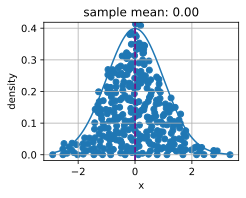

In [1]:
import torch
from d2l import torch as d2l

torch.pi = torch.acos(torch.zeros(1)) * 2  #define pi in torch

# Sample datapoints and create y coordinate
epsilon = 0.1
torch.manual_seed(8675309)
xs = torch.randn(size=(300,))

ys = torch.tensor(
    [torch.sum(torch.exp(-(xs[:i] - xs[i])**2 / (2 * epsilon**2))\
               / torch.sqrt(2*torch.pi*epsilon**2)) / len(xs)\
     for i in range(len(xs))])

# Compute true density
xd = torch.arange(torch.min(xs), torch.max(xs), 0.01)
yd = torch.exp(-xd**2/2) / torch.sqrt(2 * torch.pi)

# Plot the results
d2l.plot(xd, yd, 'x', 'density')
d2l.plt.scatter(xs, ys)
d2l.plt.axvline(x=0)
d2l.plt.axvline(x=torch.mean(xs), linestyle='--', color='purple')
d2l.plt.title(f'sample mean: {float(torch.mean(xs).item()):.2f}')
d2l.plt.show()


パラメータ $\hat{\theta}_n$ の推定量を計算するには、さまざまな方法があります。このセクションでは、推定値を評価および比較するための 3 つの一般的な方法、つまり平均二乗誤差、標準偏差、統計的バイアスを紹介します。

### 平均二乗誤差

おそらく、推定量を評価するために使用される最も単純なメトリックは、次のように定義できる*平均二乗誤差 (MSE)* (または $l_2$ 損失) 推定量です。

 $$\mathrm{MSE} (\hat{\theta}_n, \theta) = E[(\hat{\theta}_n - \theta)^2].$$ :eqlabel: `eq_mse_est`

これにより、真の値からの平均二乗偏差を定量化することができます。 MSE は常に非負です。 :numref: `sec_linear_regression`を読んだことがあれば、これが最も一般的に使用される回帰損失関数であることがわかるでしょう。推定量を評価する尺度として、その値がゼロに近づくほど、推定量は真のパラメータ $\theta$ に近づきます。

### 統計的バイアス

MSE は自然な指標を提供しますが、それを大きくする可能性のある複数の異なる現象が容易に想像できます。基本的に重要な 2 つは、データセットのランダム性による推定量の変動と、推定手順に起因する推定量の系統誤差です。

まず、系統誤差を測定してみましょう。推定量 $\hat{\theta}_n$ の場合、*統計的偏り*の数学的図式は次のように定義できます。

 $$\mathrm{bias}(\hat{\theta}_n) = E(\hat{\theta}_n - \theta) = E(\hat{\theta}_n) - \theta.$$ :eqlabel: `eq_bias`

 $\mathrm{bias}(\hat{\theta}_n) = 0$ の場合、推定器 $\hat{\theta}_n$ の期待値はパラメータの真の値に等しいことに注意してください。この場合、$\hat{\theta}_n$ は不偏推定量であると言います。一般に、不偏推定量は、その期待値が真のパラメータと同じであるため、偏り推定量よりも優れています。

ただし、実際には偏った推定量が頻繁に使用されることに注意してください。さらなる仮定がなければ不偏推定量が存在しない場合や、計算が困難な場合があります。これは推定器の重大な欠陥のように思えるかもしれませんが、実際に遭遇する推定器の大部分は、利用可能なサンプルの数が無限に近づく傾向にあるため、バイアスがゼロになる傾向があるという意味で、少なくとも漸近的に不偏性です。 $\lim_{n \rightarrow \infty} \mathrm{bias}(\hat{\theta}_n) = 0$。

### 分散と標準偏差

次に、推定器のランダム性を測定しましょう。 :numref: `sec_random_variables`を思い出してください。*標準偏差*(または*標準誤差*) は分散の平方根として定義されます。推定量の標準偏差または分散を測定することによって、推定量の変動の程度を測定する場合があります。

 $$\sigma_{\hat{\theta}_n} = \sqrt{\mathrm{Var} (\hat{\theta}_n )} = \sqrt{E[(\hat{\theta}_n - E(\ hat{\theta}_n))^2]}.$$ :eqlabel: `eq_var_est`

 :eqref: `eq_var_est`と :eqref: `eq_mse_est`を比較することが重要です。この式では、母集団の真の値 $\theta$ と比較するのではなく、標本平均値の期待値 $E(\hat{\theta}_n)$ と比較します。したがって、推定量が真の値からどの程度離れているかを測定しているのではなく、推定量自体の変動を測定しています。

### バイアスと分散のトレードオフ

これら 2 つの主成分が平均二乗誤差に寄与していることは直感的に明らかです。やや衝撃的なのは、これが実際には平均二乗誤差をこれら 2 つの寄与分と 3 番目の寄与分に*分解したもので*あることが示せることです。つまり、平均二乗誤差は、バイアス、分散、既約誤差の二乗の和として書くことができます。

 $$ \begin{aligned} \mathrm{MSE} (\hat{\theta}_n, \theta) &amp;= E[(\hat{\theta}_n - \theta)^2] \ &amp;= E[(\ hat{\theta}_n)^2] + E[\theta^2] - 2E[\hat{\theta}_n\theta] \ &amp;= \mathrm{Var} [\hat{\theta}_n] + E [\hat{\theta}_n]^2 + \mathrm{Var} [\theta] + E[\theta]^2 - 2E[\hat{\theta}_n]E[\theta] \ &amp;= (E [\hat{\theta}_n] - E[\theta])^2 + \mathrm{Var} [\hat{\theta}_n] + \mathrm{Var} [\theta] \ &amp;= (E[\ hat{\theta}_n - \theta])^2 + \mathrm{Var} [\hat{\theta}_n] + \mathrm{Var} [\theta] \ &amp;= (\mathrm{bias} [\hat {\theta}_n])^2 + \mathrm{Var} (\hat{\theta}_n) + \mathrm{Var} [\theta].\ \end{aligned} $$

上の式を*「バイアスと分散のトレードオフ」*と呼びます。平均二乗誤差は、高バイアスによる誤差、高分散による誤差、および既約誤差の 3 つの誤差原因に分類できます。バイアス誤差は、特徴と出力の間の高次元の関係を抽出できない単純なモデル (線形回帰モデルなど) でよく見られます。モデルが高いバイアス誤差に悩まされている場合、(:numref: `sec_generalization_basics` ) で紹介されているように、モデルが*アンダーフィッティング*または*柔軟性*に欠けているとよく言われます。高い分散は通常、モデルが複雑すぎるために発生し、トレーニング データを過剰適合させます。その結果、*過学習*モデルはデータの小さな変動に敏感になります。モデルに高い分散が発生している場合、(:numref: `sec_generalization_basics` ) で紹介されているように、モデルが過学習で*一般化*が欠如*し*ているとよく言われます。還元不可能な誤差は、$\theta$ 自体のノイズの結果です。

### コードでの推定値の評価

推定器の標準偏差は、テンソル`a`に対して`a.std()`を呼び出すだけで実装されているため、それをスキップしますが、統計的バイアスと平均二乗誤差を実装します。


In [2]:
# Statistical bias
def stat_bias(true_theta, est_theta):
    return(torch.mean(est_theta) - true_theta)

# Mean squared error
def mse(data, true_theta):
    return(torch.mean(torch.square(data - true_theta)))


バイアスと分散のトレードオフの方程式を説明するために、$10,000$ のサンプルを使用して正規分布 $\mathcal{N}(\theta, \sigma^2)$ をシミュレートしてみましょう。ここでは、$\theta = 1$ および $\sigma = 4$ を使用します。推定量は与えられたサンプルの関数であるため、ここでは正規分布 $\mathcal{N}(\theta, \sigma^2)$ における真の $\theta$ の推定量としてサンプルの平均を使用します。


In [3]:
theta_true = 1
sigma = 4
sample_len = 10000
samples = torch.normal(theta_true, sigma, size=(sample_len, 1))
theta_est = torch.mean(samples)
theta_est

tensor(1.0170)


二乗バイアスと推定量の分散の合計を計算して、トレードオフ方程式を検証してみましょう。まず、推定器の MSE を計算します。


In [4]:
mse(samples, theta_true)

tensor(16.0298)


次に $\mathrm{Var} (\hat{\theta}_n) + [\mathrm{bias} (\hat{\theta}_n)]^2$ を以下のように計算します。ご覧のとおり、2 つの値は数値精度に一致しています。


In [5]:
bias = stat_bias(theta_true, theta_est)
torch.square(samples.std(unbiased=False)) + torch.square(bias)

tensor(16.0298)


## 仮説検証の実施

統計的推論で最もよく遭遇するトピックは仮説検定です。仮説検定は 20 世紀初頭に普及しましたが、最初に使用したのは 1700 年代のジョン アーバスノットまで遡ります。ジョンはロンドンで 80 年間の出生記録を追跡し、毎年女性よりも男性の方が多く生まれると結論付けました。その後、現代の有意性検定は、$p$ 値とピアソンのカイ 2 乗検定を発明したカール ピアソン、スチューデントの t 分布の父であるウィリアム ゴセット、帰無仮説と有意性テスト。

*仮説検定は、*母集団に関するデフォルトのステートメントに対していくつかの証拠を評価する方法です。デフォルトのステートメントを*帰無仮説*$H_0$ と呼び、観察されたデータを使用してこれを棄却しようとします。ここでは、統計的有意性検定の開始点として $H_0$ を使用します。*対立仮説*$H_A$ (または $H_1$) は、帰無仮説に反するステートメントです。帰無仮説は、多くの場合、変数間の関係を仮定する宣言的な形式で述べられます。概要を可能な限り明確に反映し、統計理論によってテスト可能である必要があります。

あなたが化学者であると想像してください。研究室で何千時間も費やした後、数学を理解する能力を劇的に向上させる新薬を開発しました。その魔法の力を示すには、それをテストする必要があります。当然のことながら、薬を飲んで数学の学習がより良くなるかどうかを確認してくれるボランティアが必要になるかもしれません。どうやって始めますか?

まず、いくつかの指標によって測定される数学的理解能力に差がないように、慎重にランダムに選択された 2 つのボランティア グループが必要です。 2 つのグループは、一般にテスト グループとコントロール グループと呼ばれます。*テストグループ*(または*治療グループ*) は薬を体験する個人のグループですが、*対照グループ*はベンチマークとして用意されたユーザーのグループ、つまり、この薬の服用以外は同一の環境設定をしたユーザーのグループを表します。このようにして、治療における独立変数の影響を除くすべての変数の影響が最小限に抑えられます。

次に、薬を一定期間服用した後、ボランティアに新しい数式を学習させた後に同じテストをさせるなど、同じ指標で 2 つのグループの数学的理解度を測定する必要があります。その後、パフォーマンスを収集し、結果を比較できます。この場合、帰無仮説は 2 つのグループ間に差がないというものになり、代替仮説は差があるというものになります。

これはまだ完全に正式なものではありません。慎重に考えなければならない詳細がたくさんあります。たとえば、数学的理解力をテストするのに適した指標は何でしょうか?あなたの薬の有効性を自信を持って主張できるように、あなたの検査に何人のボランティアが参加してくれますか?テストはどれくらいの期間実行する必要がありますか? 2 つのグループ間に違いがあるかどうかをどのように判断しますか?平均的なパフォーマンスのみを重視しますか、それともスコアの変動範囲も重視しますか?等々。

このように、仮説検定は、実験計画と観察結果の確実性についての推論のためのフレームワークを提供します。帰無仮説が真実である可能性が非常に低いことが証明できれば、自信を持って帰無仮説を棄却できるでしょう。

仮説テストの使い方の説明を完了するには、いくつかの追加の用語を導入し、上記の概念の一部を正式なものにする必要があります。

### 統計的有意性

*統計的有意性は*、帰無仮説 $H_0$ が棄却されるべきでないときに誤って棄却される確率を測定します。

 $$ \text{統計的有意性 }= 1 - \alpha = 1 - P(\text{拒否 } H_0 \mid H_0 \text{ は true} ).$$

これは、*タイプ I エラー*または*誤検知*とも呼ばれます。 $\alpha$ は*有意水準*と呼ばれ、一般的に使用される値は $5%$、つまり $1-\alpha = 95%$ です。有意水準は、真の帰無仮説を棄却するときに喜んで引き受けるリスクのレベルとして説明できます。

 :numref: `fig_statistical_significance` 2 標本の仮説検定における特定の正規分布の観測値と確率を示します。観察データの例が $95%$ しきい値の外側にある場合、帰無仮説の仮定の下では、その観察は非常に可能性が低いことになります。したがって、帰無仮説には何か問題がある可能性があり、それを棄却します。

![](../img/statistical-significance.svg) :label: `fig_statistical_significance`

### 統計力

*統計的検出力*(または*感度*) は、帰無仮説 $H_0$ が棄却されるべき場合に、帰無仮説が棄却される確率を測定します。

 $$ \text{統計的検出力 }= 1 - \beta = 1 - P(\text{ 拒否に失敗しました } H_0 \mid H_0 \text{ は false} ).$$

*タイプ I エラーは、帰*無仮説が真であるときに帰無仮説を棄却することによって引き起こされるエラーであるのに対し、*タイプ II エラーは、*帰無仮説が偽であるときに帰無仮説を棄却できないことによって引き起こされるエラーであることを思い出してください。タイプ II エラーは通常 $\beta$ として表されるため、対応する統計検出力は $1-\beta$ となります。

直感的には、統計検出力は、テストが望ましい統計的有意水準で最小の大きさの実際の不一致を検出する可能性がどの程度であるかとして解釈できます。 $80%$ は、一般的に使用される統計的検出力のしきい値です。統計的検出力が高いほど、真の違いを検出できる可能性が高くなります。

統計的検出力の最も一般的な用途の 1 つは、必要なサンプル数を決定することです。帰無仮説が偽である場合にその帰無仮説を棄却する確率は、その帰無仮説がどの程度偽であるか (*効果サイズ*と呼ばれます) とサンプルの数によって異なります。ご想像のとおり、効果の大きさが小さい場合、高い確率で検出するには非常に多くのサンプルが必要になります。この簡単な付録では詳細を導き出すことはできませんが、例として、サンプルが平均ゼロ分散 1 ガウスから来ており、サンプルの平均が実際には 1 に近いと信じているという帰無仮説を棄却できるようにしたいと考えています。 、わずか$8$のサンプルサイズで許容可能なエラー率でそれを行うことができます。ただし、サンプル母集団の真の平均値が $0.01$ に近いと考えられる場合、違いを検出するには $80000$ 近くのサンプル サイズが必要になります。

浄水器としての力が想像できます。この例えで言えば、高出力の仮説テストは、水中の有害物質をできる限り減らす高品質の水ろ過システムのようなものです。一方、差が小さい場合は、低品質の浄水フィルターのようなもので、比較的小さな物質が隙間から簡単に漏れ出す可能性があります。同様に、統計検出力の検出力が十分に高くない場合、検定では小さな不一致が検出されない可能性があります。

### テスト統計

*検定統計量*$T(x)$ は、サンプル データの特性を要約するスカラーです。このような統計を定義する目的は、さまざまな分布を区別し、仮説検定を実行できるようにすることです。化学者の例を思い出してみると、ある母集団のパフォーマンスが他の母集団よりも優れていることを示したい場合、平均値を検定統計量として採用するのが合理的かもしれません。検定統計量の選択が異なると、大幅に異なる統計検出力を持つ統計検定が行われる可能性があります。

多くの場合、$T(X)$ (帰無仮説に基づく検定統計量の分布) は、帰無仮説に基づいて考慮した場合、少なくともほぼ、正規分布などの一般的な確率分布に従います。このような分布を明示的に導出して、データセットの検定統計量を測定できれば、統計量が予想の範囲を大きく外れていても帰無仮説を安全に棄却できます。これを定量的にすると、$p$ 値の概念が導き出されます。

###  $p$-値

$p$ 値 (または*確率値*) は、帰無仮説が*真で*あると仮定して、 $T(X)$ が観測された検定統計量 $T(x)$ と少なくとも同じくらい極端である確率です。

 $$ p\text{-value} = P_{H_0}(T(X) \geq T(x)).$$

 $p$ 値が事前に定義された固定の統計的有意水準 $\alpha$ 以下の場合、帰無仮説を棄却する可能性があります。そうでない場合は、帰無仮説を棄却する証拠が不足していると結論付けることになります。特定の母集団分布の場合、*棄却領域は*、統計的有意水準 $\alpha$ より小さい $p$ 値を持つすべての点が含まれる区間になります。

### 片面テストと両面テスト

通常、有意性検定には片側検定と両側検定の 2 種類があります。*片側検定*(または*片側検定*) は、帰無仮説と対立仮説が一方向のみの場合に適用できます。たとえば、帰無仮説は、真のパラメータ $\theta$ が値 $c$ 以下であると述べている場合があります。対立仮説は、$\theta$ が $c$ よりも大きいということになります。つまり、棄却領域は標本分布の片側にのみ存在します。片側検定とは対照的に、*両側検定*(または*両側検定*) は、棄却領域が標本分布の両側にある場合に適用できます。この場合の例では、真のパラメータ $\theta$ が値 $c$ に等しいという帰無仮説状態が考えられます。対立仮説は、$\theta$ が $c$ に等しくないということになります。

### 仮説検定の一般的な手順

上記の概念を理解したら、仮説検証の一般的な手順を見てみましょう。
1. 質問を述べ、帰無仮説 $H_0$ を確立します。
1. 統計的有意水準 $\alpha$ と統計的検出力 ($1 - \beta$) を設定します。
1. 実験を通じてサンプルを入手します。必要なサンプルの数は、統計的検出力と予想される効果の大きさによって異なります。
1. 検定統計量と $p$ 値を計算します。
1.  $p$ 値と統計的有意水準 $\alpha$ に基づいて、帰無仮説を維持するか棄却するかを決定します。

仮説検定を実行するには、帰無仮説と許容するリスクのレベルを定義することから始めます。次に、帰無仮説に対する証拠として検定統計量の極値を取得して、サンプルの検定統計量を計算します。検定統計量が棄却領域内にある場合、帰無仮説を棄却して対立仮説を支持する可能性があります。

仮説テストは、臨床試験や A/B テストなどのさまざまなシナリオに適用できます。

## 信頼区間の構築

パラメータ $\theta$ の値を推定する場合、 $\hat \theta$ のような点推定器は不確実性の概念を含まないため、その有用性は限られています。むしろ、真のパラメータ $\theta$ を高い確率で含む区間を生成できれば、はるかに優れています。 1 世紀前にそのようなアイデアに興味があったなら、この概念を最初に導入したイェジー ネイマンの「古典的確率理論に基づく統計的推定理論の概要」を読んで興奮したでしょう :cite: `Neyman.1937` 1937 年の信頼区間。

信頼区間を有効にするには、一定の確実性を得るために信頼区間をできるだけ小さくする必要があります。それを導出する方法を見てみましょう。

### 意味

数学的には、真のパラメータ $\theta$ の*信頼区間は*、次のようなサンプル データから計算された区間 $C_n$ です。

 $$P_{\theta} (C_n \ni \theta) \geq 1 - \alpha, \forall \theta.$$ :eqlabel: `eq_confidence`

ここで、 $\alpha \in (0, 1)$ および $1 - \alpha$ は、*信頼水準*または区間の*範囲*と呼ばれます。これは、上で説明した有意水準と同じ $\alpha$ です。

 :eqref: `eq_confidence`変数 $C_n$ に関するものであり、固定 $\theta$ に関するものではないことに注意してください。これを強調するために、$P_{\theta} (\theta \in C_n)$ ではなく $P_{\theta} (C_n \ni \theta)$ と書きます。

### 解釈

$95%$ 信頼区間を、真のパラメータが存在することを $95%$ 確信できる区間として解釈するのは非常に誘惑的ですが、残念ながらこれは真実ではありません。真のパラメータは固定されており、ランダムな間隔です。したがって、より適切な解釈は、この手順で多数の信頼区間を生成した場合、生成された区間の $95%$ に真のパラメータが含まれるということになります。

これは衒学的に見えるかもしれませんが、結果の解釈に大きな影響を与える可能性があります。特に、十分にまれにしか実行しない限り、真の値が含まれていないことが*ほぼ確実な*区間を構築することによって、:eqref: `eq_confidence`を満たすことができます。このセクションは、魅力的だが誤った 3 つのステートメントを提供して終了します。これらの点についての詳細な説明は、:citet: `Morey.Hoekstra.Rouder.ea.2016`にあります。
- **誤謬１** ．信頼区間が狭いということは、パラメーターを正確に推定できることを意味します。
- **誤謬２** ．信頼区間内の値は、区間外の値よりも真の値である可能性が高くなります。
- **誤謬３** ．特定の観察された $95%$ 信頼区間に真の値が含まれる確率は $95%$ です。

信頼区間は微妙なオブジェクトであると言えば十分でしょう。ただし、解釈を明確にしておけば、強力なツールになる可能性があります。

### ガウスの例

最も古典的な例である、平均と分散が未知のガウス分布の平均の信頼区間について説明します。ガウス $\mathcal{N}(\mu, \sigma^2)$ から $n$ 個のサンプル ${x_i}_{i=1}^n$ を収集するとします。次のようにして、平均と分散の推定量を計算できます。

 $$\hat\mu_n = \frac{1}{n}\sum_{i=1}^n x_i ;\text{and}; \hat\sigma^2_n = \frac{1}{n-1}\sum_{i=1}^n (x_i - \hat\mu)^2.$$

ここで確率変数を考えてみると

$$ T = \frac{\hat\mu_n - \mu}{\hat\sigma_n/\sqrt{n}}, $$

 $n-1$*自由度**のスチューデントの t 分布*と呼ばれるよく知られた分布に従う確率変数を取得します。

この分布は非常によく研究されており、たとえば、 $n\rightarrow \infty$ として、ほぼ標準ガウスであることが知られているため、テーブルでガウス cdf の値を調べると、次のように結論付けることができます。 $T$ の値は、少なくとも $95%$ の確率で $[-1.96, 1.96]$ の範囲内にあります。 $n$ の有限値の場合、間隔を多少大きくする必要がありますが、これはよく知られており、表で事前に計算されています。

したがって、$n$ が大きい場合、次のように結論付けることができます。

 $$ P\left(\frac{\hat\mu_n - \mu}{\hat\sigma_n/\sqrt{n}} \in [-1.96, 1.96]\right) \ge 0.95。 $$

これを両辺に $\hat\sigma_n/\sqrt{n}$ を掛け、$\hat\mu_n$ を加算して整理すると、次のようになります。

 $$ P\left(\mu \in \left[\hat\mu_n - 1.96\frac{\hat\sigma_n}{\sqrt{n}}, \hat\mu_n + 1.96\frac{\hat\sigma_n}{ \sqrt{n}}\right]\right) \ge 0.95。 $$

したがって、$95%$ 信頼区間が見つかったことがわかります: $$\left[\hat\mu_n - 1.96\frac{\hat\sigma_n}{\sqrt{n}}, \hat\mu_n + 1.96\frac{ \hat\sigma_n}{\sqrt{n}}\right].$$ :eqlabel: `eq_gauss_confidence`

 :eqref: `eq_gauss_confidence` 、統計学で最もよく使用される式の 1 つであると言っても過言ではありません。統計を実装して、統計の議論を終えましょう。簡単にするために、漸近領域にあると仮定します。 $N$ の小さな値には、プログラムまたは $t$-table から取得された`t_star`の正しい値が含まれている必要があります。


In [6]:
# PyTorch uses Bessel's correction by default, which means the use of ddof=1
# instead of default ddof=0 in numpy. We can use unbiased=False to imitate
# ddof=0.

# Number of samples
N = 1000

# Sample dataset
samples = torch.normal(0, 1, size=(N,))

# Lookup Students's t-distribution c.d.f.
t_star = 1.96

# Construct interval
mu_hat = torch.mean(samples)
sigma_hat = samples.std(unbiased=True)
(mu_hat - t_star*sigma_hat/torch.sqrt(torch.tensor(N, dtype=torch.float32)),\
 mu_hat + t_star*sigma_hat/torch.sqrt(torch.tensor(N, dtype=torch.float32)))

(tensor(-0.0568), tensor(0.0704))


## まとめ
- 統計は推論問題に焦点を当てますが、ディープラーニングは明示的にプログラミングして理解することなく正確な予測を行うことに重点を置きます。
- 一般的な統計推論方法には、推定量の評価と比較、仮説検定の実施、信頼区間の構築の 3 つがあります。
- 最も一般的な推定量には、統計的バイアス、標準偏差、平均二乗誤差の 3 つがあります。
- 信頼区間は、与えられたサンプルから構築できる真の母集団パラメータの推定範囲です。
- 仮説検定は、母集団に関するデフォルトのステートメントに対していくつかの証拠を評価する方法です。

## 演習
1. $X_1, X_2, \ldots, X_n \overset{\text{iid}}{\sim} \mathrm{Unif}(0, \theta)$ とします。ここで、「iid」は*独立かつ同一分散*を表します。 $\theta$ の次の推定量を考えてみましょう: $$\hat{\theta} = \max {X_1, X_2, \ldots, X_n };$$ $$\tilde{\theta} = 2 \bar{X_n} = \frac{2}{n} \sum_{i=1}^n X_i.$$<ul><li> $\hat{\theta} の統計的偏り、標準偏差、平均二乗誤差を求めます。$
1.  $\tilde{\theta}.$ の統計的偏り、標準偏差、平均二乗誤差を求めます。
1. どちらの見積もりが良いでしょうか?
</ul></li>1. 冒頭の化学者の例について、両面仮説検定を実施するための 5 つのステップを導き出すことができますか?統計的有意水準 $\alpha = 0.05$ および統計検出力 $1 - \beta = 0.8$ と仮定します。
1. 独立して生成された $100$ データセットに対して $N=2$ および $\alpha = 0.5$ を使用して信頼区間コードを実行し、結果の区間をプロットします (この場合は`t_star = 1.0` )。真の平均 $0$ からは程遠い、非常に短い間隔がいくつか見られます。これは信頼区間の解釈と矛盾しますか?高精度の推定値を示すために短い間隔を使用することに抵抗はありませんか?



[ディスカッション](https://discuss.d2l.ai/t/1102)
